In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import os
import time
import pickle
import numpy as np

pd.options.mode.chained_assignment = None  # default='warn'
ROOT = os.path.dirname(os.getcwd())

In [2]:
#metrics
player_network_base = pd.read_pickle(os.path.join(ROOT, 'intermediates', 'player_passing_networks_exploration.pkl.gz'))
zone_network_base = pd.read_pickle(os.path.join(ROOT, 'intermediates', 'zonal_passing_networks_exploration.pkl.gz'))
lane_intensity = pd.read_pickle(os.path.join(ROOT, 'intermediates', 'zone_lane_info_clustered.pkl.gz')) #includes cluster assignment for k=2
lane_cluster_centers = pd.read_pickle(os.path.join(ROOT, 'intermediates', 'zone_lane_info_cluster_centers.pkl.gz')).sort_index()
advance_ratio = pd.read_pickle(os.path.join(ROOT, 'intermediates', 'advance_ratio.pkl.gz'))
player_network_advanced = pd.read_pickle(os.path.join(ROOT, 'intermediates', 'player_network_algorithms.pkl.gz'))
defensive_metrics_normalized = pd.read_pickle(os.path.join(ROOT, 'intermediates', 'defensive_metrics_normalized_by_possession.pkl.gz'))
atts_defense = ['possession',
        'yellow_card/possession',
        'total_fouls/possession',
        'dangerous_ball_lost/possession',
        'interception_total/possession',
        'interception_inside_box/possession',
        'sliding_tackle_total/possession',
        'sliding_tackle_inside_box/possession',
        'fraction_slide_tackles_in_box',
        'fraction_interception_in_box',
        'centroid_slidetackles_interceptions_y',
        'centroid_slidetackles_interceptions_x',
        'fouls_committed',
        'yellow_card_per_foul_committed']
defensive_metrics_normalized  = defensive_metrics_normalized [atts_defense]

#performance
match_goals_wins = pd.read_pickle(os.path.join(ROOT, 'intermediates', 'matches_goals_wins.pkl.gz'))
performance = pd.read_pickle(os.path.join(ROOT, 'intermediates', 'team_performance.pkl.gz'))

#Combining eveything
df = pd.concat([player_network_base,
                zone_network_base,
                lane_intensity[['cluster']].droplevel(1, axis=1).rename({'cluster': 'passing_lane_cluster'}, axis=1), #Only considering clusters for now
                advance_ratio,
                player_network_advanced,
                defensive_metrics_normalized], axis=1)
df = df.drop(columns = ['fouls_committed', 'yellow_card_per_foul_committed', 'possession', 'total_fouls/possession'])

#### Feature Preprocessing & Standardization

To collapse the 20 features from a per game granularity to a per team level, instead of simply averaging, I am taking the mean, median, min, max, and variance across all these dimensions - making it closer to 100 features

In [3]:
#df = df.mean(level=1)
#assert 0
#Collapsing from per match to per team level
df = pd.concat([df.mean(level=1), df.median(level=1), df.max(level=1), df.min(level=1), df.var(level=1)],
         keys=['mean', 'median', 'max', 'min', 'var'], axis=1)

# Equal weightage in euclidean space for clustering
df = (df - df.mean())/df.std()
#feats_pre_aggregation = df.copy()

In [4]:
df

mean                                                          \
             w mean_passes_players std_passes_players mean_passes_zone   
1609  1.936797            1.993363           1.887977         2.009746   
1631 -0.569432           -0.571528          -0.468623        -0.579093   
1625  3.350016            3.406662           3.400785         3.017362   
1651 -0.698530           -0.603258          -0.754753        -0.715641   
1610  1.246287            1.251096           1.332306         1.599085   
...        ...                 ...                ...              ...   
3219 -0.183033           -0.253692           0.019928        -0.167924   
3193 -0.305870           -0.351561          -0.322652        -0.266909   
3315 -0.875034           -0.881524          -0.810637        -0.808535   
3163 -0.525306           -0.588668          -0.661436        -0.457265   
3165 -0.527990           -0.521211          -0.213069        -0.596352   

                                                         \
     std_passes_zone passing_lane_cluster advance_ratio   
1609        1.384351             2.020265      1.706638   
1631       -0.510147            -0.329204     -0.342721   
1625        3.390555             2.167107      2.126620   
1651       -0.826652            -1.797623     -0.300204   
1610        0.856457             0.698689      1.084321   
...              ...                  ...           ...   
3219       -0.085709            -0.182362      0.354051   
3193       -0.505610            -0.182362     -0.202459   
3315       -1.032875            -1.063413     -0.481081   
3163       -0.330596            -0.769730     -0.024488   
3165       -0.742170            -0.622888      0.124748   

                                                        \
     avg_clustering_coefficient algebraic_connectivity   
1609                   1.979335               0.942322   
1631                  -0.366233              -0.955545   
1625                   2.703903               2.277908   
1651                  -0.293391              -0.582852   
1610                   0.901086               1.193123   
...                         ...                    ...   
3219                  -0.072669              -0.575642   
3193                  -1.094088               0.391742   
3315                  -1.230323              -1.366720   
3163                  -0.780457               0.615376   
3165                  -0.288404              -1.454929   

                                  ...                    var  \
     avg_shortest_path_all_pairs  ... yellow_card/possession   
1609                   -1.666993  ...              -0.220527   
1631                    0.619364  ...              -0.551183   
1625                   -2.465925  ...              -1.027938   
1651                    0.665354  ...              -0.749088   
1610                   -1.402504  ...              -0.694944   
...                          ...  ...                    ...   
3219                    0.218342  ...              -0.167027   
3193                    0.086493  ...              -0.555785   
3315                    1.102206  ...               1.852978   
3163                    0.321176  ...               0.594771   
3165                    0.872364  ...               0.768195   

                                                                   \
     dangerous_ball_lost/possession interception_total/possession   
1609                       0.789182                     -0.778890   
1631                      -0.359889                      0.734001   
1625                      -0.534604                     -1.004716   
1651                       1.014534                      0.495403   
1610                      -0.036124                     -0.339540   
...                             ...                           ...   
3219                       0.716250                     -0.274312   
3193                       0.187168                     -0.327417   
3

#### K-Means

C:\Users\musta\anaconda3\envs\DSenv\lib\site-packages\sklearn\cluster\_kmeans.py:881: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(


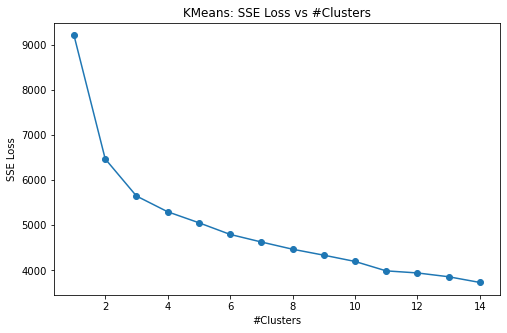

In [5]:
from sklearn.cluster import KMeans


plt.figure(figsize=(8, 5))
plt.plot([i for i in range(1,15)],
         [KMeans(n_clusters=i, random_state=0).fit(df.fillna(0)).inertia_ for i in range(1,15)], 'o-')

plt.title('KMeans: SSE Loss vs #Clusters')
plt.xlabel('#Clusters')
plt.ylabel('SSE Loss')
#plt.savefig('../figures/passing_lane_k_means/elbow_curve.png', bbox_inches='tight')
plt.show()

In [6]:
df

mean                                                          \
             w mean_passes_players std_passes_players mean_passes_zone   
1609  1.936797            1.993363           1.887977         2.009746   
1631 -0.569432           -0.571528          -0.468623        -0.579093   
1625  3.350016            3.406662           3.400785         3.017362   
1651 -0.698530           -0.603258          -0.754753        -0.715641   
1610  1.246287            1.251096           1.332306         1.599085   
...        ...                 ...                ...              ...   
3219 -0.183033           -0.253692           0.019928        -0.167924   
3193 -0.305870           -0.351561          -0.322652        -0.266909   
3315 -0.875034           -0.881524          -0.810637        -0.808535   
3163 -0.525306           -0.588668          -0.661436        -0.457265   
3165 -0.527990           -0.521211          -0.213069        -0.596352   

                                                         \
     std_passes_zone passing_lane_cluster advance_ratio   
1609        1.384351             2.020265      1.706638   
1631       -0.510147            -0.329204     -0.342721   
1625        3.390555             2.167107      2.126620   
1651       -0.826652            -1.797623     -0.300204   
1610        0.856457             0.698689      1.084321   
...              ...                  ...           ...   
3219       -0.085709            -0.182362      0.354051   
3193       -0.505610            -0.182362     -0.202459   
3315       -1.032875            -1.063413     -0.481081   
3163       -0.330596            -0.769730     -0.024488   
3165       -0.742170            -0.622888      0.124748   

                                                        \
     avg_clustering_coefficient algebraic_connectivity   
1609                   1.979335               0.942322   
1631                  -0.366233              -0.955545   
1625                   2.703903               2.277908   
1651                  -0.293391              -0.582852   
1610                   0.901086               1.193123   
...                         ...                    ...   
3219                  -0.072669              -0.575642   
3193                  -1.094088               0.391742   
3315                  -1.230323              -1.366720   
3163                  -0.780457               0.615376   
3165                  -0.288404              -1.454929   

                                  ...                    var  \
     avg_shortest_path_all_pairs  ... yellow_card/possession   
1609                   -1.666993  ...              -0.220527   
1631                    0.619364  ...              -0.551183   
1625                   -2.465925  ...              -1.027938   
1651                    0.665354  ...              -0.749088   
1610                   -1.402504  ...              -0.694944   
...                          ...  ...                    ...   
3219                    0.218342  ...              -0.167027   
3193                    0.086493  ...              -0.555785   
3315                    1.102206  ...               1.852978   
3163                    0.321176  ...               0.594771   
3165                    0.872364  ...               0.768195   

                                                                   \
     dangerous_ball_lost/possession interception_total/possession   
1609                       0.789182                     -0.778890   
1631                      -0.359889                      0.734001   
1625                      -0.534604                     -1.004716   
1651                       1.014534                      0.495403   
1610                      -0.036124                     -0.339540   
...                             ...                           ...   
3219                       0.716250                     -0.274312   
3193                       0.187168                     -0.327417   
3

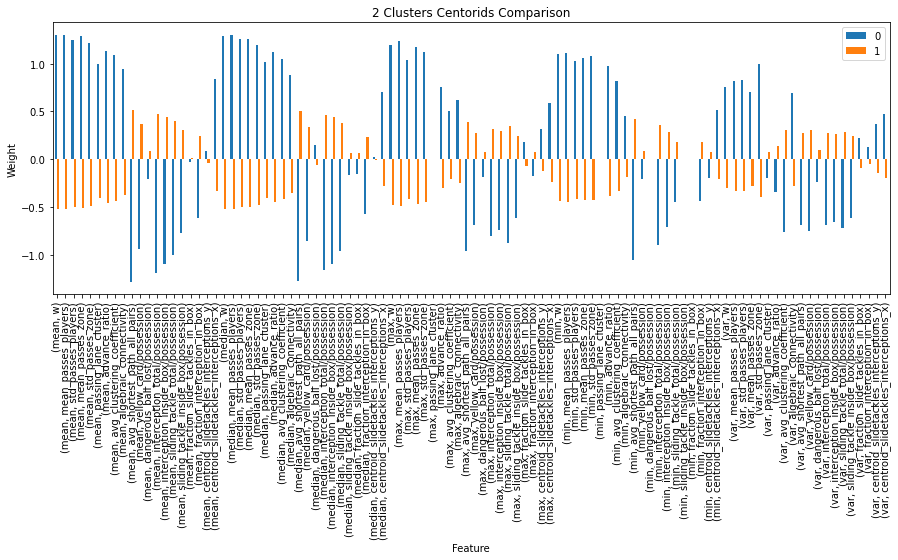

In [7]:
kmeans_classifier = KMeans(n_clusters=2, random_state=0).fit(df.fillna(0))
df['CLUSTER_GLOBAL'] = kmeans_classifier.labels_
cluster_centers = pd.DataFrame(kmeans_classifier.cluster_centers_).iloc[:, :].T
cluster_centers.index = df.columns[:-1]
cluster_centers.plot(kind='bar', figsize=(15, 5))
plt.xlabel('Feature')
plt.ylabel('Weight')
plt.title('2 Clusters Centorids Comparison')
plt.show()

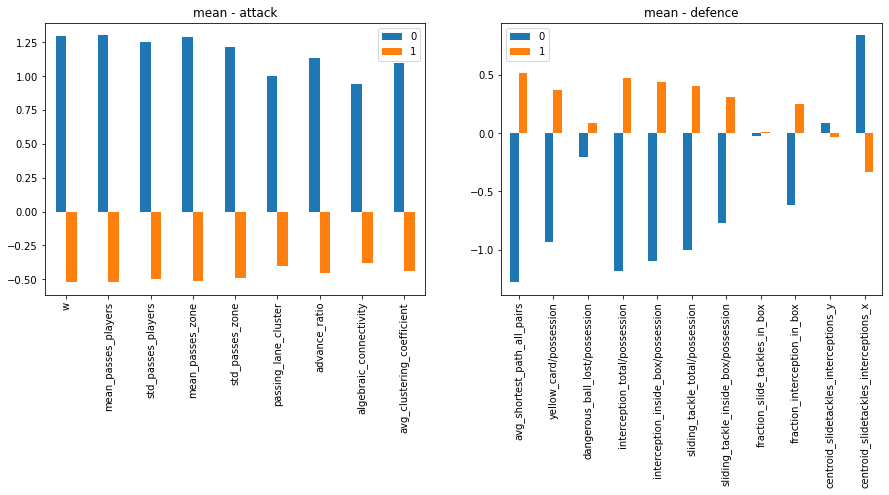

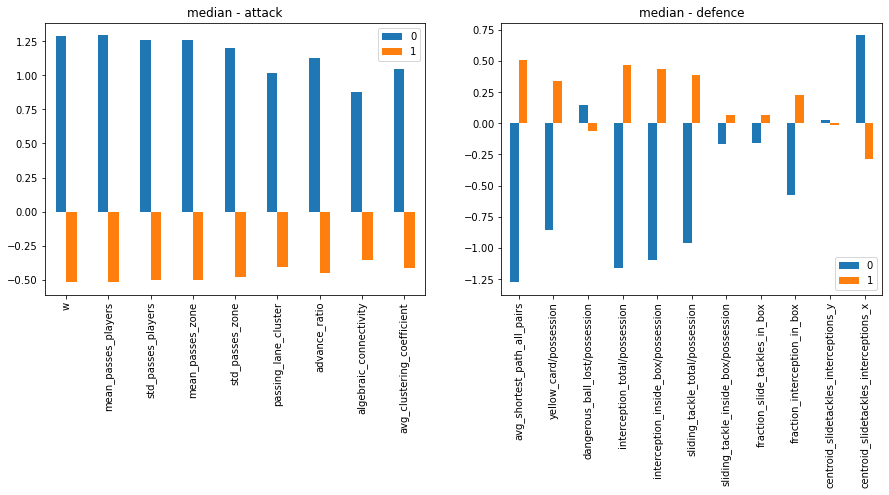

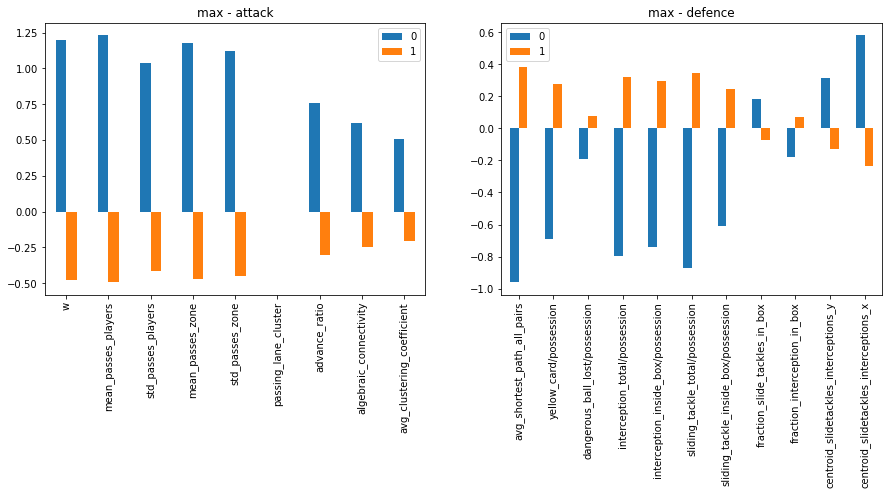

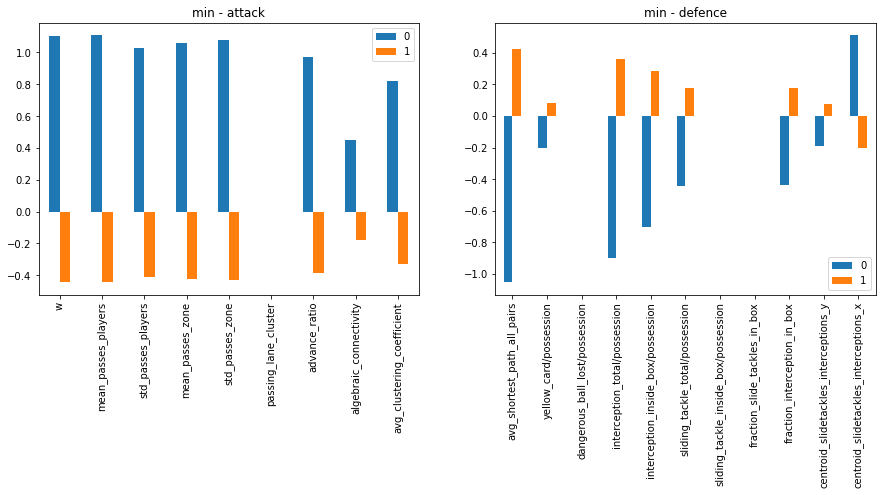

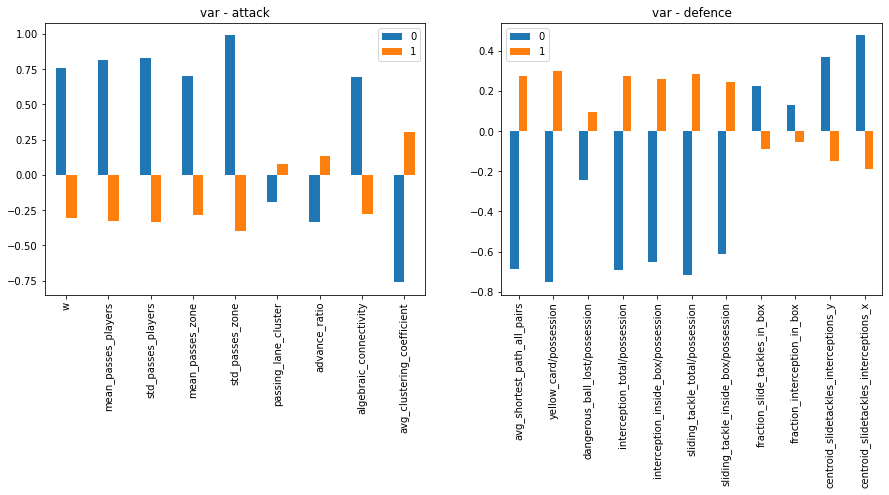

In [8]:
attack_feats = ['w', 'mean_passes_players', 'std_passes_players', 'mean_passes_zone', 'std_passes_zone', 'passing_lane_cluster',
               'advance_ratio', 'algebraic_connectivity', 'avg_clustering_coefficient']
defence_feats = [f for f in df['mean'].columns if f not in attack_feats]

for aggr in ['mean', 'median', 'max', 'min', 'var']:
    fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(15, 5))
    cluster_centers.loc[aggr].loc[attack_feats].plot(kind='bar', ax=axes[0], title=aggr+' - attack')
    cluster_centers.loc[aggr].loc[defence_feats].plot(kind='bar', ax=axes[1], title=aggr+' - defence')
    plt.show()

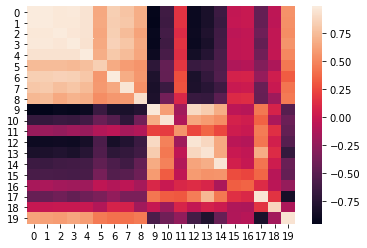

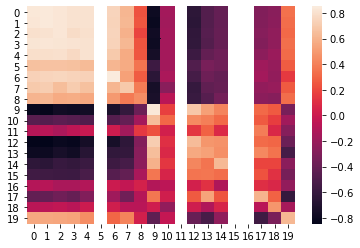

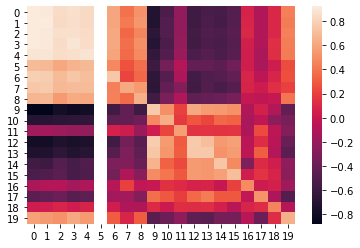

In [9]:
import seaborn as sns

for aggr in ['median', 'min', 'max']:
    plt.plot()
    tmp = df[['mean', aggr]].corr().loc['mean', aggr]
    sns.heatmap(tmp.to_numpy())
    plt.show()

In [10]:
original_data = df.drop(columns=['CLUSTER_GLOBAL']).copy()
original_data = original_data[['mean', 'var']]
original_data


mean                                                          \
             w mean_passes_players std_passes_players mean_passes_zone   
1609  1.936797            1.993363           1.887977         2.009746   
1631 -0.569432           -0.571528          -0.468623        -0.579093   
1625  3.350016            3.406662           3.400785         3.017362   
1651 -0.698530           -0.603258          -0.754753        -0.715641   
1610  1.246287            1.251096           1.332306         1.599085   
...        ...                 ...                ...              ...   
3219 -0.183033           -0.253692           0.019928        -0.167924   
3193 -0.305870           -0.351561          -0.322652        -0.266909   
3315 -0.875034           -0.881524          -0.810637        -0.808535   
3163 -0.525306           -0.588668          -0.661436        -0.457265   
3165 -0.527990           -0.521211          -0.213069        -0.596352   

                                                         \
     std_passes_zone passing_lane_cluster advance_ratio   
1609        1.384351             2.020265      1.706638   
1631       -0.510147            -0.329204     -0.342721   
1625        3.390555             2.167107      2.126620   
1651       -0.826652            -1.797623     -0.300204   
1610        0.856457             0.698689      1.084321   
...              ...                  ...           ...   
3219       -0.085709            -0.182362      0.354051   
3193       -0.505610            -0.182362     -0.202459   
3315       -1.032875            -1.063413     -0.481081   
3163       -0.330596            -0.769730     -0.024488   
3165       -0.742170            -0.622888      0.124748   

                                                        \
     avg_clustering_coefficient algebraic_connectivity   
1609                   1.979335               0.942322   
1631                  -0.366233              -0.955545   
1625                   2.703903               2.277908   
1651                  -0.293391              -0.582852   
1610                   0.901086               1.193123   
...                         ...                    ...   
3219                  -0.072669              -0.575642   
3193                  -1.094088               0.391742   
3315                  -1.230323              -1.366720   
3163                  -0.780457               0.615376   
3165                  -0.288404              -1.454929   

                                  ...                    var  \
     avg_shortest_path_all_pairs  ... yellow_card/possession   
1609                   -1.666993  ...              -0.220527   
1631                    0.619364  ...              -0.551183   
1625                   -2.465925  ...              -1.027938   
1651                    0.665354  ...              -0.749088   
1610                   -1.402504  ...              -0.694944   
...                          ...  ...                    ...   
3219                    0.218342  ...              -0.167027   
3193                    0.086493  ...              -0.555785   
3315                    1.102206  ...               1.852978   
3163                    0.321176  ...               0.594771   
3165                    0.872364  ...               0.768195   

                                                                   \
     dangerous_ball_lost/possession interception_total/possession   
1609                       0.789182                     -0.778890   
1631                      -0.359889                      0.734001   
1625                      -0.534604                     -1.004716   
1651                       1.014534                      0.495403   
1610                      -0.036124                     -0.339540   
...                             ...                           ...   
3219                       0.716250                     -0.274312   
3193                       0.187168                     -0.327417   
3

#### Try PCA maybe?

Something is very weird here

In [11]:
df = df.drop(columns='CLUSTER_GLOBAL')
df

mean                                                          \
             w mean_passes_players std_passes_players mean_passes_zone   
1609  1.936797            1.993363           1.887977         2.009746   
1631 -0.569432           -0.571528          -0.468623        -0.579093   
1625  3.350016            3.406662           3.400785         3.017362   
1651 -0.698530           -0.603258          -0.754753        -0.715641   
1610  1.246287            1.251096           1.332306         1.599085   
...        ...                 ...                ...              ...   
3219 -0.183033           -0.253692           0.019928        -0.167924   
3193 -0.305870           -0.351561          -0.322652        -0.266909   
3315 -0.875034           -0.881524          -0.810637        -0.808535   
3163 -0.525306           -0.588668          -0.661436        -0.457265   
3165 -0.527990           -0.521211          -0.213069        -0.596352   

                                                         \
     std_passes_zone passing_lane_cluster advance_ratio   
1609        1.384351             2.020265      1.706638   
1631       -0.510147            -0.329204     -0.342721   
1625        3.390555             2.167107      2.126620   
1651       -0.826652            -1.797623     -0.300204   
1610        0.856457             0.698689      1.084321   
...              ...                  ...           ...   
3219       -0.085709            -0.182362      0.354051   
3193       -0.505610            -0.182362     -0.202459   
3315       -1.032875            -1.063413     -0.481081   
3163       -0.330596            -0.769730     -0.024488   
3165       -0.742170            -0.622888      0.124748   

                                                        \
     avg_clustering_coefficient algebraic_connectivity   
1609                   1.979335               0.942322   
1631                  -0.366233              -0.955545   
1625                   2.703903               2.277908   
1651                  -0.293391              -0.582852   
1610                   0.901086               1.193123   
...                         ...                    ...   
3219                  -0.072669              -0.575642   
3193                  -1.094088               0.391742   
3315                  -1.230323              -1.366720   
3163                  -0.780457               0.615376   
3165                  -0.288404              -1.454929   

                                  ...                    var  \
     avg_shortest_path_all_pairs  ... yellow_card/possession   
1609                   -1.666993  ...              -0.220527   
1631                    0.619364  ...              -0.551183   
1625                   -2.465925  ...              -1.027938   
1651                    0.665354  ...              -0.749088   
1610                   -1.402504  ...              -0.694944   
...                          ...  ...                    ...   
3219                    0.218342  ...              -0.167027   
3193                    0.086493  ...              -0.555785   
3315                    1.102206  ...               1.852978   
3163                    0.321176  ...               0.594771   
3165                    0.872364  ...               0.768195   

                                                                   \
     dangerous_ball_lost/possession interception_total/possession   
1609                       0.789182                     -0.778890   
1631                      -0.359889                      0.734001   
1625                      -0.534604                     -1.004716   
1651                       1.014534                      0.495403   
1610                      -0.036124                     -0.339540   
...                             ...                           ...   
3219                       0.716250                     -0.274312   
3193                       0.187168                     -0.327417   
3

In [12]:
from sklearn.decomposition import PCA

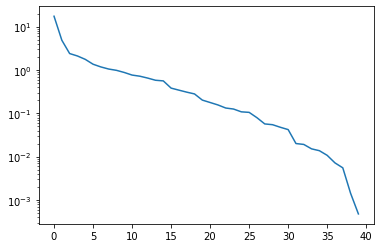

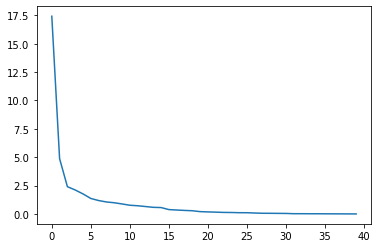

In [13]:
pca = PCA(svd_solver='full')
df = pca.fit_transform(original_data.fillna(0))
df = pd.DataFrame(df).fillna(0)
plt.plot(pca.explained_variance_)
#plt.figure()
#plt.plot(pca.explained_variance_[: 20])
plt.yscale('log')
plt.show()
plt.plot(pca.explained_variance_)
plt.show()



In [14]:
original_data

mean                                                          \
             w mean_passes_players std_passes_players mean_passes_zone   
1609  1.936797            1.993363           1.887977         2.009746   
1631 -0.569432           -0.571528          -0.468623        -0.579093   
1625  3.350016            3.406662           3.400785         3.017362   
1651 -0.698530           -0.603258          -0.754753        -0.715641   
1610  1.246287            1.251096           1.332306         1.599085   
...        ...                 ...                ...              ...   
3219 -0.183033           -0.253692           0.019928        -0.167924   
3193 -0.305870           -0.351561          -0.322652        -0.266909   
3315 -0.875034           -0.881524          -0.810637        -0.808535   
3163 -0.525306           -0.588668          -0.661436        -0.457265   
3165 -0.527990           -0.521211          -0.213069        -0.596352   

                                                         \
     std_passes_zone passing_lane_cluster advance_ratio   
1609        1.384351             2.020265      1.706638   
1631       -0.510147            -0.329204     -0.342721   
1625        3.390555             2.167107      2.126620   
1651       -0.826652            -1.797623     -0.300204   
1610        0.856457             0.698689      1.084321   
...              ...                  ...           ...   
3219       -0.085709            -0.182362      0.354051   
3193       -0.505610            -0.182362     -0.202459   
3315       -1.032875            -1.063413     -0.481081   
3163       -0.330596            -0.769730     -0.024488   
3165       -0.742170            -0.622888      0.124748   

                                                        \
     avg_clustering_coefficient algebraic_connectivity   
1609                   1.979335               0.942322   
1631                  -0.366233              -0.955545   
1625                   2.703903               2.277908   
1651                  -0.293391              -0.582852   
1610                   0.901086               1.193123   
...                         ...                    ...   
3219                  -0.072669              -0.575642   
3193                  -1.094088               0.391742   
3315                  -1.230323              -1.366720   
3163                  -0.780457               0.615376   
3165                  -0.288404              -1.454929   

                                  ...                    var  \
     avg_shortest_path_all_pairs  ... yellow_card/possession   
1609                   -1.666993  ...              -0.220527   
1631                    0.619364  ...              -0.551183   
1625                   -2.465925  ...              -1.027938   
1651                    0.665354  ...              -0.749088   
1610                   -1.402504  ...              -0.694944   
...                          ...  ...                    ...   
3219                    0.218342  ...              -0.167027   
3193                    0.086493  ...              -0.555785   
3315                    1.102206  ...               1.852978   
3163                    0.321176  ...               0.594771   
3165                    0.872364  ...               0.768195   

                                                                   \
     dangerous_ball_lost/possession interception_total/possession   
1609                       0.789182                     -0.778890   
1631                      -0.359889                      0.734001   
1625                      -0.534604                     -1.004716   
1651                       1.014534                      0.495403   
1610                      -0.036124                     -0.339540   
...                             ...                           ...   
3219                       0.716250                     -0.274312   
3193                       0.187168                     -0.327417   
3

C:\Users\musta\anaconda3\envs\DSenv\lib\site-packages\sklearn\cluster\_kmeans.py:881: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(


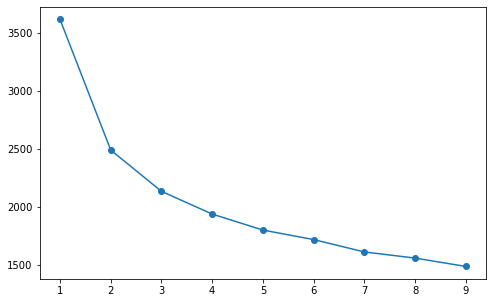

In [15]:
pca = PCA(svd_solver='full', n_components=15)
df = pca.fit_transform(original_data.fillna(0))
df = pd.DataFrame(df).fillna(0)

plt.figure(figsize=(8, 5))
plt.plot([i for i in range(1,10)],
         [KMeans(n_clusters=i, random_state=0).fit(df.fillna(0)).inertia_ for i in range(1,10)], 'o-')

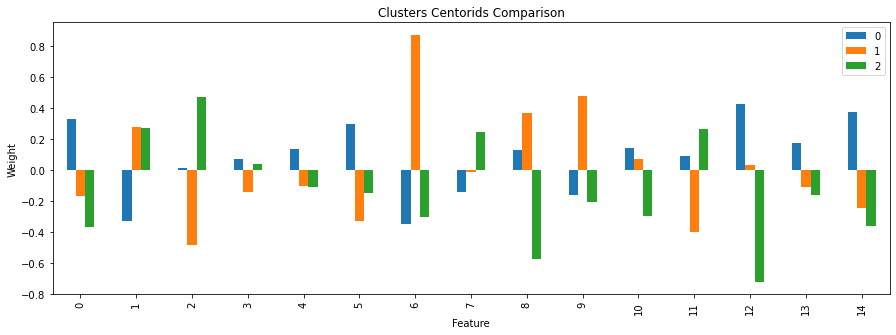

In [16]:
try: 
    df = df.drop(columns=['CLUSTER_GLOBAL'])
except:
    pass
df = (df-df.mean())/df.std()
kmeans_classifier = KMeans(n_clusters=3, random_state=0).fit(df)
df['CLUSTER_GLOBAL'] = kmeans_classifier.labels_
cluster_centers = pd.DataFrame(kmeans_classifier.cluster_centers_).iloc[:, :].T
cluster_centers.index = df.columns[:-1]
cluster_centers.plot(kind='bar', figsize=(15, 5))
plt.xlabel('Feature')
plt.ylabel('Weight')
plt.title('Clusters Centorids Comparison')
plt.show()

In [17]:
df = df[['CLUSTER_GLOBAL']]
df.index = original_data.index
df = pd.concat([df, matches, perf[['area.name', 'end_of_season_pts']]], axis=1).set_index('CLUSTER_GLOBAL')
df.loc[df['area.name']=='Germany', ['end_of_season_pts', 'goals_scored', 'goals_conceded']] = df.loc[df['area.name']=='Germany', ['end_of_season_pts', 'goals_scored', 'goals_conceded']]/34
df.loc[df['area.name']!='Germany', ['end_of_season_pts', 'goals_scored', 'goals_conceded']] = df.loc[df['area.name']!='Germany', ['end_of_season_pts', 'goals_scored', 'goals_conceded']]/38
df = df.groupby(df.index).mean()
((df-df.mean())/df.std()).T.plot(kind='bar', figsize = (8, 5))

NameError: name 'matches' is not defined

In [18]:
pd.Series(pca.components_[0], index=original_data.columns).to_frame('principal_comp_0')

principal_comp_0
mean w                                              0.230225
     mean_passes_players                            0.230477
     std_passes_players                             0.226655
     mean_passes_zone                               0.229769
     std_passes_zone                                0.222339
     passing_lane_cluster                           0.180019
     advance_ratio                                  0.197795
     avg_clustering_coefficient                     0.204003
     algebraic_connectivity                         0.177221
     avg_shortest_path_all_pairs                   -0.228124
     yellow_card/possession                        -0.169238
     dangerous_ball_lost/possession                -0.071421
     interception_total/possession                 -0.223984
     interception_inside_box/possession            -0.215108
     sliding_tackle_total/possession               -0.176369
     sliding_tackle_inside_box/possession          -0.167013
     fraction_slide_tackles_in_box                 -0.037721
     fraction_interception_in_box                  -0.130184
     centroid_slidetackles_interceptions_y         -0.003316
     centroid_slidetackles_interceptions_x          0.162307
var  w                                              0.137657
     mean_passes_players                            0.144306
     std_passes_players                             0.166883
     mean_passes_zone                               0.125876
     std_passes_zone                                0.186770
     passing_lane_cluster                          -0.025719
     advance_ratio                                 -0.039200
     avg_clustering_coefficient                    -0.150842
     algebraic_connectivity                         0.151866
     avg_shortest_path_all_pairs                   -0.129428
     yellow_card/possession                        -0.157900
     dangerous_ball_lost/possession                -0.078567
     interception_total/possession                 -0.148698
     interception_inside_box/possession            -0.141880
     sliding_tackle_total/possession               -0.137876
     sliding_tackle_inside_box/possession          -0.141120
     fraction_slide_tackles_in_box                  0.018288
     fraction_interception_in_box                   0.034974
     centroid_slidetackles_interceptions_y          0.073720
     centroid_slidetackles_interceptions_x          0.085977

# Get 3 very diff clusters with PCA, top 15 components. Now lets try doing the same with MI - picking the top 15 (or k) features with maximum mutual infor with perf.

In [19]:
original_data

mean                                                          \
             w mean_passes_players std_passes_players mean_passes_zone   
1609  1.936797            1.993363           1.887977         2.009746   
1631 -0.569432           -0.571528          -0.468623        -0.579093   
1625  3.350016            3.406662           3.400785         3.017362   
1651 -0.698530           -0.603258          -0.754753        -0.715641   
1610  1.246287            1.251096           1.332306         1.599085   
...        ...                 ...                ...              ...   
3219 -0.183033           -0.253692           0.019928        -0.167924   
3193 -0.305870           -0.351561          -0.322652        -0.266909   
3315 -0.875034           -0.881524          -0.810637        -0.808535   
3163 -0.525306           -0.588668          -0.661436        -0.457265   
3165 -0.527990           -0.521211          -0.213069        -0.596352   

                                                         \
     std_passes_zone passing_lane_cluster advance_ratio   
1609        1.384351             2.020265      1.706638   
1631       -0.510147            -0.329204     -0.342721   
1625        3.390555             2.167107      2.126620   
1651       -0.826652            -1.797623     -0.300204   
1610        0.856457             0.698689      1.084321   
...              ...                  ...           ...   
3219       -0.085709            -0.182362      0.354051   
3193       -0.505610            -0.182362     -0.202459   
3315       -1.032875            -1.063413     -0.481081   
3163       -0.330596            -0.769730     -0.024488   
3165       -0.742170            -0.622888      0.124748   

                                                        \
     avg_clustering_coefficient algebraic_connectivity   
1609                   1.979335               0.942322   
1631                  -0.366233              -0.955545   
1625                   2.703903               2.277908   
1651                  -0.293391              -0.582852   
1610                   0.901086               1.193123   
...                         ...                    ...   
3219                  -0.072669              -0.575642   
3193                  -1.094088               0.391742   
3315                  -1.230323              -1.366720   
3163                  -0.780457               0.615376   
3165                  -0.288404              -1.454929   

                                  ...                    var  \
     avg_shortest_path_all_pairs  ... yellow_card/possession   
1609                   -1.666993  ...              -0.220527   
1631                    0.619364  ...              -0.551183   
1625                   -2.465925  ...              -1.027938   
1651                    0.665354  ...              -0.749088   
1610                   -1.402504  ...              -0.694944   
...                          ...  ...                    ...   
3219                    0.218342  ...              -0.167027   
3193                    0.086493  ...              -0.555785   
3315                    1.102206  ...               1.852978   
3163                    0.321176  ...               0.594771   
3165                    0.872364  ...               0.768195   

                                                                   \
     dangerous_ball_lost/possession interception_total/possession   
1609                       0.789182                     -0.778890   
1631                      -0.359889                      0.734001   
1625                      -0.534604                     -1.004716   
1651                       1.014534                      0.495403   
1610                      -0.036124                     -0.339540   
...                             ...                           ...   
3219                       0.716250                     -0.274312   
3193                       0.187168                     -0.327417   
3

In [20]:
performance = pd.read_pickle(os.path.join(ROOT, 'intermediates', 'team_performance.pkl.gz'))
performance = performance.set_index('area.name', append=True).swaplevel()[['name', 'end_of_season_pts']].sort_index()
performance['rank'] = performance.groupby(level=0).rank(pct=True)
performance['_quartile'] = pd.qcut(performance['rank'], q=4, labels=['q1', 'q2', 'q3', 'q4']) #q4 highest
performance.head(20).sort_values(by='rank')

name  end_of_season_pts   rank _quartile
area.name                                                                  
England   1627     West Bromwich Albion                 31  0.050        q1
          1639               Stoke City                 33  0.125        q1
          10531            Swansea City                 33  0.125        q1
          1619              Southampton                 36  0.200        q1
          1673        Huddersfield Town                 37  0.250        q1
          1644                  Watford                 39  0.300        q2
          1651   Brighton & Hove Albion                 41  0.350        q2
          1633          West Ham United                 42  0.400        q2
          1613         Newcastle United                 44  0.500        q2
          1659          AFC Bournemouth                 44  0.500        q2
          1628           Crystal Palace                 44  0.500        q2
          1631           Leicester City                 47  0.600        q3
          1623                  Everton                 48  0.650        q3
          1646                  Burnley                 54  0.700        q3
          1609                  Arsenal                 63  0.750        q3
          1610                  Chelsea                 70  0.800        q4
          1612                Liverpool                 75  0.850        q4
          1624        Tottenham Hotspur                 77  0.900        q4
          1611        Manchester United                 81  0.950        q4
          1625          Manchester City                100  1.000        q4

In [21]:
performance = performance[['_quartile']].droplevel(0)
performance.columns = pd.MultiIndex.from_tuples([('performance', '_quartile')])
df = pd.concat([original_data, performance], axis=1)
df

mean                                                          \
              w mean_passes_players std_passes_players mean_passes_zone   
674   -0.167827           -0.156545           0.188738        -0.032391   
675    1.727497            1.767961           1.252692         1.505684   
676    2.079013            2.030195           1.509412         1.986903   
677   -0.521132           -0.532420          -0.667215        -0.631377   
678   -0.377127           -0.377986          -0.605593        -0.227823   
...         ...                 ...                ...              ...   
3795  -0.770384           -0.834326          -0.866550        -0.956759   
3799  -0.560786           -0.578889          -0.495295        -0.750159   
3804  -0.435862           -0.457505          -0.552697        -0.343559   
10531 -0.430794           -0.450675          -0.420584        -0.375032   
19830 -0.111776           -0.110309           0.231346        -0.027823   

                                                          \
      std_passes_zone passing_lane_cluster advance_ratio   
674         -0.042805             1.579740      1.098193   
675          0.570003             1.432898      1.697164   
676          1.604240             1.726581      1.793790   
677         -0.838640             0.111321     -0.062368   
678         -0.168287             0.551847     -0.537618   
...               ...                  ...           ...   
3795        -1.013445            -1.357097     -0.591535   
3799        -0.583421            -0.769730     -0.486048   
3804        -0.463759            -0.476046     -0.011533   
10531       -0.348876            -1.063413      0.096082   
19830        0.104544             1.139214      0.531511   

                                                         \
      avg_clustering_coefficient algebraic_connectivity   
674                    -0.805537              -0.349543   
675                     1.531757               2.719036   
676                     1.441253               0.828231   
677                    -0.578830               0.227737   
678                     0.656232               1.128884   
...                          ...                    ...   
3795                   -1.160048              -0.550204   
3799                   -0.725153              -1.050818   
3804                   -0.036585              -0.873047   
10531                  -0.860792              -0.798752   
19830                  -0.404672              -0.539892   

                                   ...                            var  \
      avg_shortest_path_all_pairs  ... dangerous_ball_lost/possession   
674                      0.221485  ...                       0.036879   
675                     -1.911460  ...                      -0.192688   
676                     -2.051108  ...                      -0.495791   
677                      0.308466  ...                      -0.039190   
678                     -0.003641  ...                       2.942776   
...                           ...  ...                            ...   
3795                     0.785490  ...                      -0.199119   
3799                     0.352757  ...                      -0.718988   
3804                     0.596591  ...                       0.128352   
10531                    0.574447  ...                       5.881079   
19830                    0.077187  ...                      -0.664660   

                                                                        \
      interception_total/possession interception_inside_box/possession   
674                       -0.338944                          -0.509802   
675                       -1.119162                          -1.005823   
676                       -1.124028                          -0.949731   
677                       -0.560030                          -0.493526   
678                       -0.282790                          -0.169085   
...               

<AxesSubplot:title={'center':'Mutual Information wrt Performance Quartile'}>

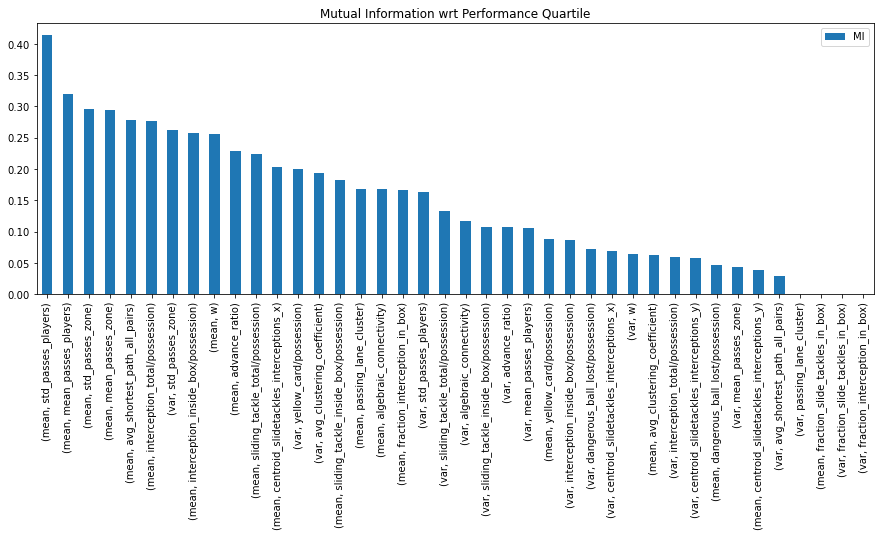

In [22]:
import sklearn.feature_selection
mutual_info = sklearn.feature_selection.mutual_info_classif(df[['mean', 'var']], df[['performance']].to_numpy().ravel())
mutual_info = pd.DataFrame(mutual_info, index=df.columns[:-1], columns=['MI'])
mutual_info.sort_values(by='MI', ascending=False).plot(kind='bar', figsize=(15, 5), title='Mutual Information wrt Performance Quartile')

### Scale the Data By MI and try GMM clustering

Initialization 0
Initialization converged: True


<AxesSubplot:>

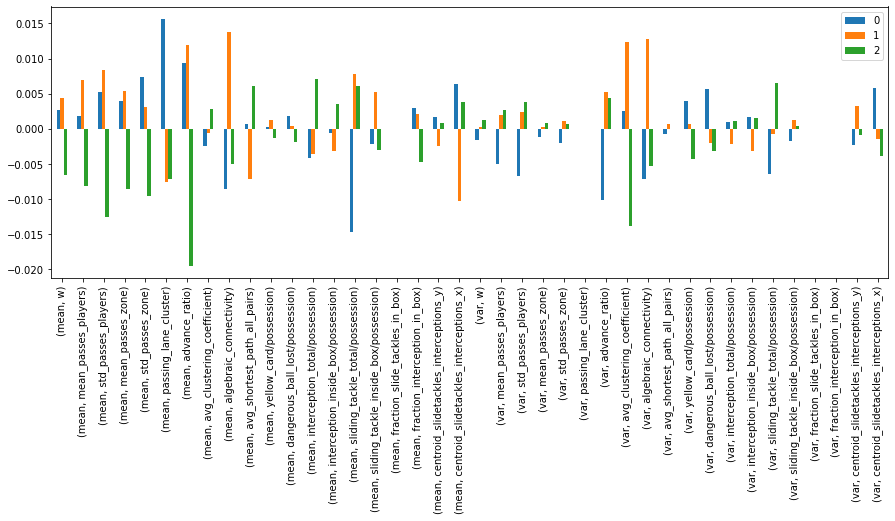

In [23]:
from sklearn.mixture import GaussianMixture as GMM

#Scale Data by MI


scaled_data = original_data.multiply(mutual_info['MI'], axis=1)
gmm = GMM(n_components=3, init_params='random', verbose=1, covariance_type='tied', random_state=0)
gmm.fit(scaled_data)

means = pd.DataFrame(gmm.means_, columns=scaled_data.columns)
means.T.plot(kind='bar', figsize=(15, 5))

In [24]:
means.T.corr()

,0,1,2
0,1.000000,-0.314065,-0.587991
1,-0.314065,1.000000,-0.583272
2,-0.587991,-0.583272,1.000000


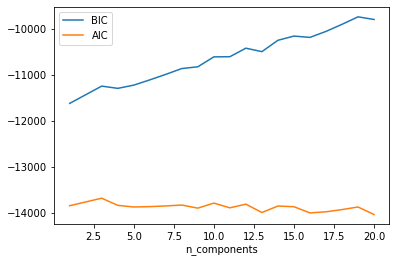

In [25]:
n_components = np.arange(1, 21)
models = [GMM(n, covariance_type='tied', random_state=0, init_params='random').fit(scaled_data)
          for n in n_components]

plt.plot(n_components, [m.bic(scaled_data) for m in models], label='BIC')
plt.plot(n_components, [m.aic(scaled_data) for m in models], label='AIC')
plt.legend(loc='best')
plt.xlabel('n_components');

In [26]:
pd.DataFrame(gmm.predict_proba(scaled_data.iloc[:, :-1]), index=scaled_data.index)

ValueError: Expected the input data X have 40 features, but got 39 features

### Scaled Data by MI, try agglor mean shift clustering

<AxesSubplot:>

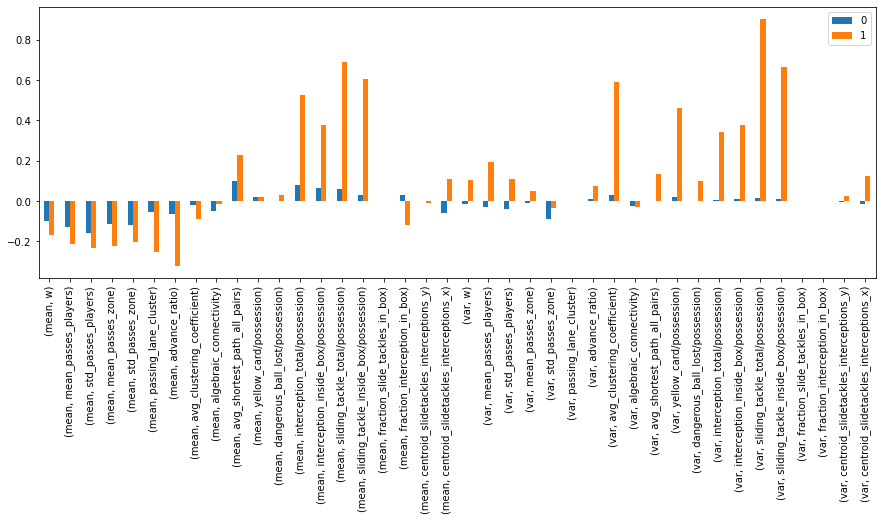

In [29]:
from sklearn.cluster import mean_shift, DBSCAN, AffinityPropagation, OPTICS, AgglomerativeClustering

cluster_centers, labels = mean_shift(scaled_data)
cluster_centers = pd.DataFrame(cluster_centers, columns=scaled_data.columns)
cluster_centers.T.plot(kind='bar', figsize=(15, 5))

In [30]:
DBSCAN().fit_predict(scaled_data)

array([-1,  0, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1,
        0, -1, -1, -1,  0, -1, -1,  1,  0, -1,  0,  0, -1, -1, -1, -1, -1,
       -1, -1, -1, -1, -1, -1, -1, -1,  0, -1, -1,  0, -1, -1, -1, -1, -1,
       -1, -1, -1, -1, -1, -1, -1, -1, -1,  1,  1, -1, -1, -1, -1, -1, -1,
       -1, -1, -1, -1, -1, -1, -1, -1, -1, -1,  1,  1,  0, -1,  1, -1, -1,
       -1, -1, -1, -1,  0,  1, -1, -1, -1,  0, -1, -1, -1], dtype=int64)

In [31]:
AffinityPropagation(verbose=True, random_state=0).fit(scaled_data).labels_

Converged after 23 iterations.


array([8, 3, 9, 4, 0, 6, 6, 1, 4, 6, 0, 4, 4, 0, 2, 4, 0, 3, 6, 4, 2, 3,
       6, 7, 7, 3, 7, 3, 3, 2, 4, 2, 3, 3, 8, 4, 0, 2, 2, 4, 9, 2, 5, 2,
       5, 5, 4, 5, 7, 5, 5, 7, 3, 3, 4, 3, 0, 2, 2, 6, 7, 7, 2, 6, 5, 3,
       2, 3, 4, 2, 8, 7, 8, 4, 3, 2, 6, 4, 7, 7, 5, 5, 7, 6, 9, 4, 7, 2,
       8, 3, 7, 4, 7, 5, 2, 6, 3, 4], dtype=int64)

In [32]:
OPTICS().fit(scaled_data).labels_

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0])

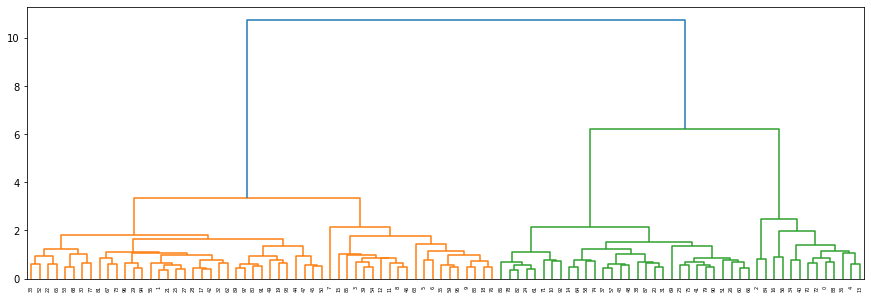

In [33]:
from scipy.cluster.hierarchy import dendrogram
def plot_dendrogram(model, **kwargs):
    # Create linkage matrix and then plot the dendrogram

    # create the counts of samples under each node
    counts = np.zeros(model.children_.shape[0])
    n_samples = len(model.labels_)
    for i, merge in enumerate(model.children_):
        current_count = 0
        for child_idx in merge:
            if child_idx < n_samples:
                current_count += 1  # leaf node
            else:
                current_count += counts[child_idx - n_samples]
        counts[i] = current_count

    linkage_matrix = np.column_stack([model.children_, model.distances_,
                                      counts]).astype(float)

    # Plot the corresponding dendrogram
    plt.figure(figsize=(15,5))
    dendrogram(linkage_matrix, **kwargs)

try:
    scaled_data = scaled_data.drop(columns='aggl_cluster')
except:
    pass

model = AgglomerativeClustering(n_clusters=3, compute_distances = True)
model.fit(scaled_data)
plot_dendrogram(model)

In [34]:
scaled_data

mean                                                          \
             w mean_passes_players std_passes_players mean_passes_zone   
1609  0.497264            0.638633           0.780596         0.593143   
1631 -0.146199           -0.183106          -0.193755        -0.170910   
1625  0.860102            1.091425           1.406076         0.890524   
1651 -0.179345           -0.193271          -0.312057        -0.211210   
1610  0.319979            0.400826           0.550850         0.471943   
...        ...                 ...                ...              ...   
3219 -0.046993           -0.081278           0.008239        -0.049560   
3193 -0.078531           -0.112633          -0.133403        -0.078774   
3315 -0.224661           -0.282422          -0.335163        -0.238626   
3163 -0.134870           -0.188597          -0.273475        -0.134954   
3165 -0.135559           -0.166985          -0.088095        -0.176003   

                                                         \
     std_passes_zone passing_lane_cluster advance_ratio   
1609        0.410711             0.341111      0.391053   
1631       -0.151351            -0.055584     -0.078530   
1625        1.005913             0.365904      0.487286   
1651       -0.245252            -0.303519     -0.068788   
1610        0.254095             0.117970      0.248458   
...              ...                  ...           ...   
3219       -0.025428            -0.030791      0.081126   
3193       -0.150005            -0.030791     -0.046391   
3315       -0.306434            -0.179552     -0.110233   
3163       -0.098082            -0.129965     -0.005611   
3165       -0.220188            -0.105171      0.028584   

                                                        \
     avg_clustering_coefficient algebraic_connectivity   
1609                   0.123004               0.158018   
1631                  -0.022759              -0.160235   
1625                   0.168031               0.381983   
1651                  -0.018233              -0.097738   
1610                   0.055997               0.200075   
...                         ...                    ...   
3219                  -0.004516              -0.096529   
3193                  -0.067991               0.065691   
3315                  -0.076457              -0.229185   
3163                  -0.048501               0.103192   
3165                  -0.017923              -0.243977   

                                  ...                    var  \
     avg_shortest_path_all_pairs  ... yellow_card/possession   
1609                   -0.463140  ...              -0.044304   
1631                    0.172078  ...              -0.110732   
1625                   -0.685107  ...              -0.206512   
1651                    0.184855  ...              -0.150491   
1610                   -0.389657  ...              -0.139614   
...                          ...  ...                    ...   
3219                    0.060662  ...              -0.033556   
3193                    0.024030  ...              -0.111657   
3315                    0.306225  ...               0.372262   
3163                    0.089232  ...               0.119489   
3165                    0.242369  ...               0.154330   

                                                                   \
     dangerous_ball_lost/possession interception_total/possession   
1609                       0.056660                     -0.046899   
1631                      -0.025838                      0.044197   
1625                      -0.038382                     -0.060497   
1651                       0.072839                      0.029830   
1610                      -0.002594                     -0.020445   
...                             ...                           ...   
3219                       0.051423                     -0.016517   
3193                       0.013438                     -0.019715   
3

(array([55.,  0.,  0.,  0.,  0., 13.,  0.,  0.,  0., 30.]),
 array([0. , 0.2, 0.4, 0.6, 0.8, 1. , 1.2, 1.4, 1.6, 1.8, 2. ]),
 <BarContainer object of 10 artists>)

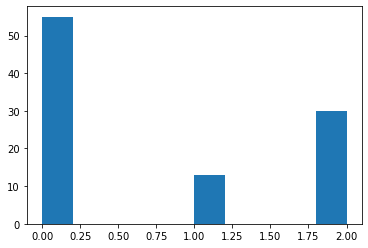

In [35]:
plt.hist(model.labels_)

aggl_cluster,0,1,2
aggl_cluster,,,
0,1.000000,-0.993527,-0.980919
1,-0.993527,1.000000,0.952484
2,-0.980919,0.952484,1.000000


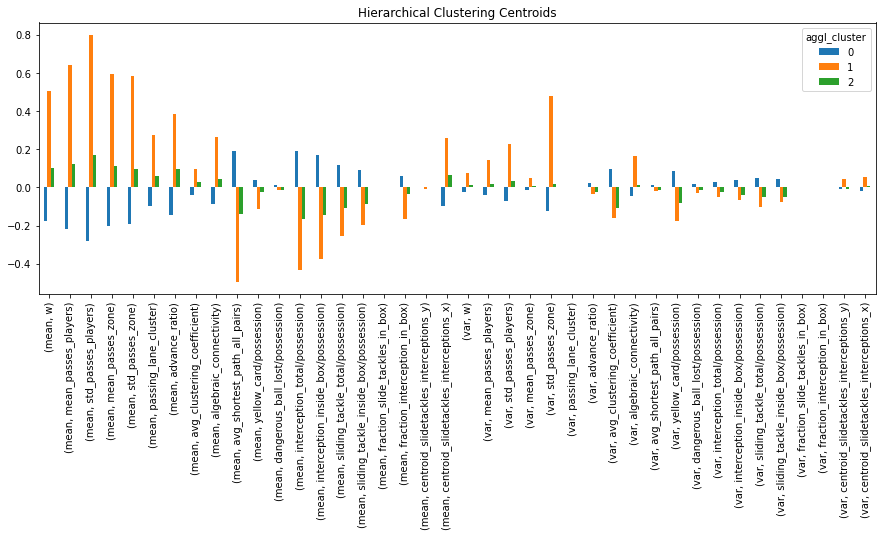

In [36]:
scaled_data['aggl_cluster'] = model.labels_
scaled_data.groupby('aggl_cluster').mean().T.plot(kind='bar', figsize=(15,5), title='Hierarchical Clustering Centroids')
display(scaled_data.groupby('aggl_cluster').mean().T.corr())
#scaled_data = scaled_data.drop(columns='aggl_cluster')

In [37]:
[print(i, c) for i, c in enumerate(scaled_data.columns)]

0 ('mean', 'w')
1 ('mean', 'mean_passes_players')
2 ('mean', 'std_passes_players')
3 ('mean', 'mean_passes_zone')
4 ('mean', 'std_passes_zone')
5 ('mean', 'passing_lane_cluster')
6 ('mean', 'advance_ratio')
7 ('mean', 'avg_clustering_coefficient')
8 ('mean', 'algebraic_connectivity')
9 ('mean', 'avg_shortest_path_all_pairs')
10 ('mean', 'yellow_card/possession')
11 ('mean', 'dangerous_ball_lost/possession')
12 ('mean', 'interception_total/possession')
13 ('mean', 'interception_inside_box/possession')
14 ('mean', 'sliding_tackle_total/possession')
15 ('mean', 'sliding_tackle_inside_box/possession')
16 ('mean', 'fraction_slide_tackles_in_box')
17 ('mean', 'fraction_interception_in_box')
18 ('mean', 'centroid_slidetackles_interceptions_y')
19 ('mean', 'centroid_slidetackles_interceptions_x')
20 ('var', 'w')
21 ('var', 'mean_passes_players')
22 ('var', 'std_passes_players')
23 ('var', 'mean_passes_zone')
24 ('var', 'std_passes_zone')
25 ('var', 'passing_lane_cluster')
26 ('var', 'advance_r

[None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None]

Text(0, 0.5, 'Std Passes Across Zones (Game to Game Variance) ')

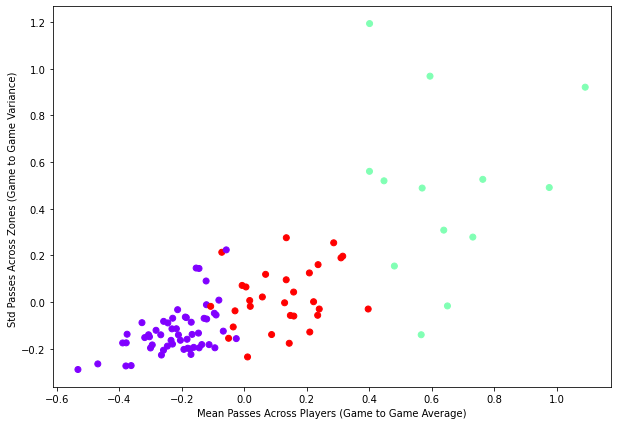

In [38]:
plt.figure(figsize=(10, 7))
plt.scatter(scaled_data.iloc[:,1], scaled_data.iloc[:,24], c=model.labels_, cmap='rainbow')
plt.xlabel('Mean Passes Across Players (Game to Game Average)')
plt.ylabel('Std Passes Across Zones (Game to Game Variance) ')

Text(0, 0.5, 'Principal Component 2')

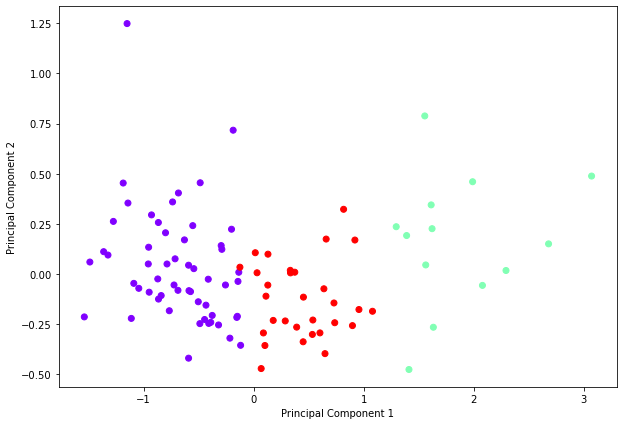

In [39]:
principal_components = pca.fit_transform(scaled_data.drop(columns='aggl_cluster'))
plt.figure(figsize=(10, 7))
plt.scatter(principal_components[:, 0], principal_components[:, 1], c=model.labels_, cmap='rainbow')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')

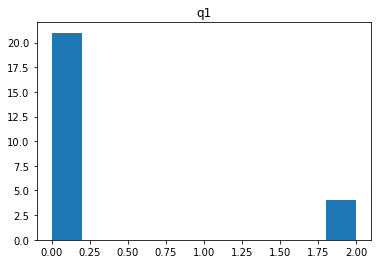

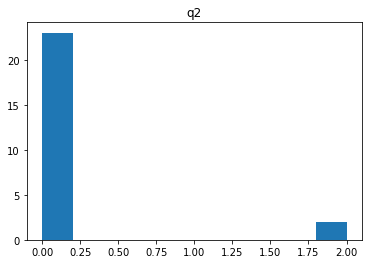

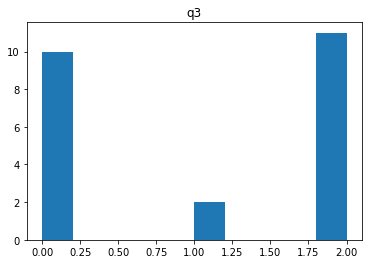

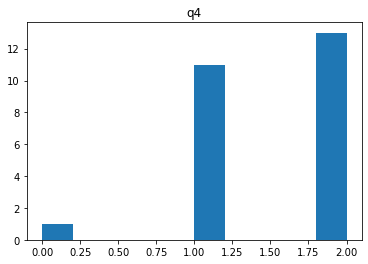

In [40]:
tmp = pd.concat([scaled_data, performance], axis=1).iloc[:, -2:]
tmp = tmp.set_index(('performance', '_quartile')).sort_index()
for gp in tmp.groupby(tmp.index):
    plt.figure()
    plt.hist(gp[1]['aggl_cluster'].to_numpy())
    plt.title(gp[0])
    plt.show()

In [41]:
perf =  pd.read_pickle(os.path.join(ROOT, 'intermediates', 'team_performance.pkl.gz'))
matches = pd.read_pickle(os.path.join(ROOT, 'processed_data', 'matches_df.pkl.gz'))[['team_home', 'team_away', 'goals_home', 'goals_away']].droplevel(1)
scored = matches.set_index('team_home')[['goals_home']].sum(level=0).rename({'goals_home': 'goals_scored'}, axis=1) + matches.set_index('team_away')[['goals_away']].sum(level=0).rename({'goals_away': 'goals_scored'}, axis=1)
conceded = matches.set_index('team_home')[['goals_away']].sum(level=0).rename({'goals_away': 'goals_conceded'}, axis=1) + matches.set_index('team_away')[['goals_home']].sum(level=0).rename({'goals_home': 'goals_conceded'}, axis=1)
matches = pd.concat([scored, conceded], axis=1)
matches['GD'] = matches['goals_scored'] - matches['goals_conceded']


df = pd.concat([scaled_data.iloc[:, -1], perf[['area.name','avg_pass_per_game', 'avg_shots_per_game', 'end_of_season_pts']], matches],
             axis=1)
df = df.set_index(('aggl_cluster', ''))
#df = df.groupby(df.index).mean()
#df.drop

df.loc[df['area.name']=='Germany', ['end_of_season_pts', 'goals_scored', 'goals_conceded']] = df.loc[df['area.name']=='Germany', ['end_of_season_pts', 'goals_scored', 'goals_conceded']]/34
df.loc[df['area.name']!='Germany', ['end_of_season_pts', 'goals_scored', 'goals_conceded']] = df.loc[df['area.name']!='Germany', ['end_of_season_pts', 'goals_scored', 'goals_conceded']]/38

df = df.groupby(df.index).mean()
df

,avg_pass_per_game,avg_shots_per_game,end_of_season_pts,goals_scored,goals_conceded,GD
"(aggl_cluster, )",,,,,,
0,368.676696,9.848016,1.096144,1.048888,1.482747,-16.272727
1,602.785663,14.454394,2.110026,2.209216,0.973327,46.230769
2,462.987564,11.885707,1.569040,1.547420,1.287564,9.800000


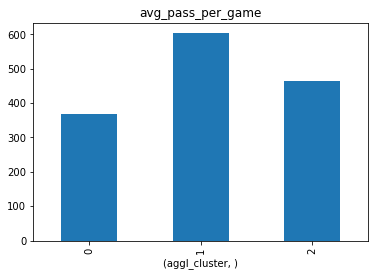

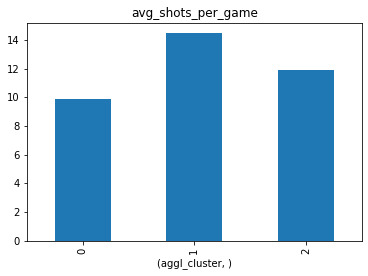

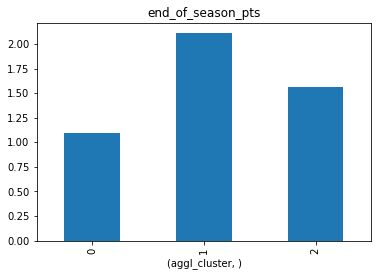

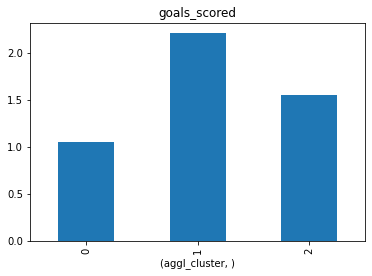

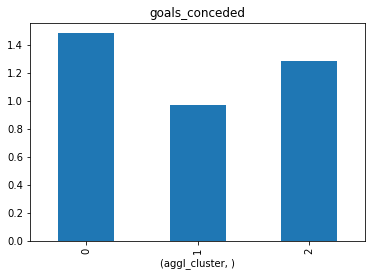

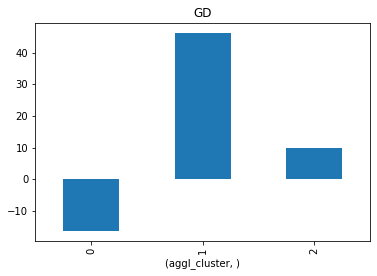

In [42]:
for c in df.columns:
    plt.figure()
    df[c].plot(kind='bar', title=c)
    plt.show()

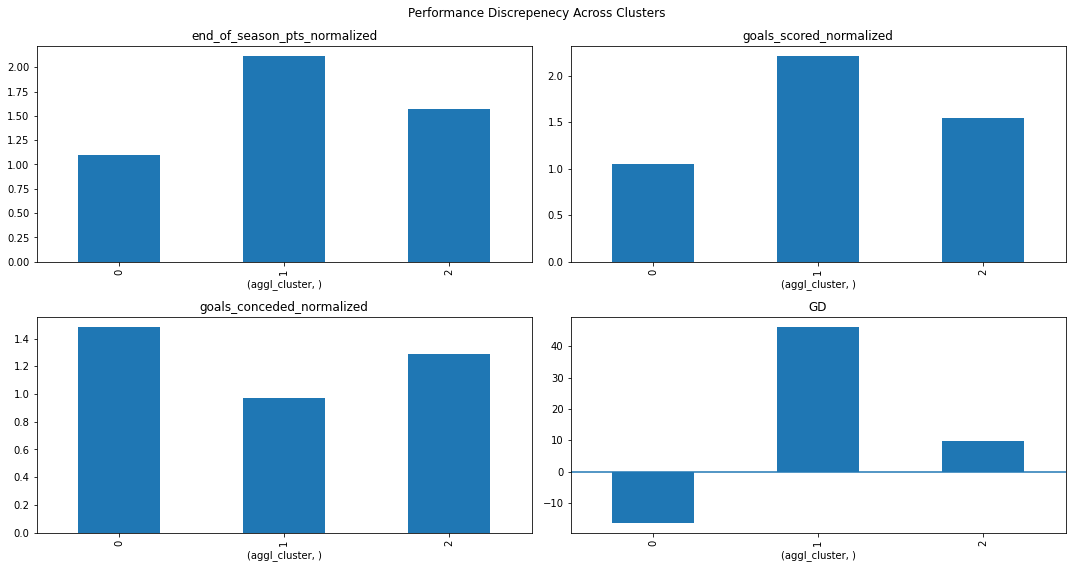

In [43]:
fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(15, 8))
df['end_of_season_pts'].plot(kind='bar', title='end_of_season_pts_normalized', ax=axes[0, 0])
df['goals_scored'].plot(kind='bar', title='goals_scored_normalized', ax=axes[0, 1])
df['goals_conceded'].plot(kind='bar', title='goals_conceded_normalized', ax=axes[1, 0])
df['GD'].plot(kind='bar', title='GD', ax=axes[1, 1])
axes[1,1].axhline(0)
plt.suptitle('Performance Discrepenecy Across Clusters')
plt.tight_layout()
plt.show()